# Multi-Layer Perceptron (MLP) Model (apartment data)

In this notebook, we will use a Multi-Layer Perceptron (MLP) Model to predict rental prices of apartments. A Multi-Layer Perceptron (MLP) model is a type of artificial neural network that consists of multiple layers of neurons. Each neuron in a layer is connected to every neuron in the previous and next layers, forming a fully connected network. The MLP model is capable of learning complex patterns in the data through backpropagation and gradient descent.

The key components of an MLP model include:
- **Input Layer**: The layer that receives the input features.
- **Hidden Layers**: One or more layers where the neurons apply weights and activation functions to the inputs to learn intermediate representations.
- **Output Layer**: The layer that produces the final prediction.

In this notebook, we will:
1. Preprocess the apartment data, including scaling the features.
2. Define and compile the MLP model using TensorFlow/Keras.
3. Train the model on the training data.
4. Evaluate the model on the test data.
5. Visualize the training process and the model's performance.


## Libraries and settings

In [16]:
# Libraries
import os
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

u:\Lektionen\GitHub_Repositories\python_machine_learning_basics\Neural_Networks


## Import the apartment data

In [17]:
# Define columns for import
columns = [ 'web-scraper-order',
            'address_raw',
            'rooms',
            'area',
            'luxurious',
            'price',
            'price_per_m2',
            'lat',
            'lon',
            'bfs_number',
            'bfs_name',
            'pop',
            'pop_dens',
            'frg_pct',
            'emp',
            'mean_taxable_income',
            'dist_supermarket']

# Read and select variables
df_orig = pd.read_csv("./Data/apartments_data_enriched_cleaned.csv", sep=";", encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & 
            (df['price'] <= 5000)]

# Reset index
df = df.reset_index(drop=True)

print(df.shape)
df.head(5)

(722, 17)


,id,address_raw,rooms,area,luxurious,price,price_per_m2,lat,lon,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,mean_taxable_income,dist_supermarket
0,1693998201-1,"Neuhusstrasse 6, 8630 Rüti ZH, ZH",3.0,49,0,1441,29.41,47.252171,8.845797,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,645.652248
1,1693998233-172,"Widacherstrasse 5, 8630 Rüti ZH, ZH",3.0,111,0,2600,23.42,47.252087,8.854919,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,265.102153
2,1693998256-331,"Widenweg 14, 8630 Rüti ZH, ZH",3.0,58,0,1490,25.69,47.253670,8.853993,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,94.401821
3,1693998265-381,"Rain 1, 8630 Rüti ZH, ZH",4.0,118,0,3240,27.46,47.259834,8.851705,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,106.660970
4,1693998276-419,"Bachtelstrasse 24b, 8630 Rüti ZH, ZH",3.0,66,0,1450,21.97,47.266113,8.866872,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,974.844209


## Rescale features using a Min-Max Scaler

In [18]:
# List of features to re-scale
features_to_scale = ['area', 
                     'rooms',
                     'lat',
                     'lon',
                     'pop',
                     'pop_dens',
                     'frg_pct',
                     'emp',
                     'mean_taxable_income',
                     'dist_supermarket']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


## Create train and test samples (train = 80%, test = 20% of the data)

In [19]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df[features_to_scale], 
                                                    df['price'], 
                                                    test_size=0.20, 
                                                    random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
         area     rooms       lat       lon       pop  pop_dens   frg_pct  \
456  0.411765  0.846154  0.361445  0.887293  0.009952  0.016427  0.206503   
6    0.196078  0.384615  0.637867  0.195518  0.005904  0.093306  0.149322   
362  0.294118  0.384615  0.749858  0.192933  0.010772  0.071666  0.439201   
594  0.188235  0.230769  0.500230  0.406181  0.046320  0.203936  0.669363   
439  0.298039  0.384615  0.145885  1.000000  0.022402  0.066417  0.491679   

          emp  mean_taxable_income  dist_supermarket  
456  0.003682             0.030066          0.591051  
6    0.001043             0.439563          0.082871  
362  0.001985             0.090126          0.787478  
594  0.075905             0.079723          0.168520  
439  0.006783             0.000000          0.193446   

y_train:
456    1900
6      1850
362    2090
594    2102
439    1800
Name: price, dtype: int64


## Train the Multi-Layer Perceptron (MLP) Model

In [20]:
# Define the number of features
num_features = X_train.shape[1]

# Define the model with dropout
model = Sequential([
    Dense(64, activation='relu', input_shape=(num_features,)),  # Hidden layer 1
    Dropout(0.2),                                               # Dropout layer 1
    Dense(32, activation='relu'),                               # Hidden layer 2
    Dropout(0.2),                                               # Dropout layer 2
    Dense(16, activation='relu'),                               # Hidden layer 3
    Dropout(0.2),                                               # Dropout layer 3
    Dense(1)                                                    # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    validation_split=0.20, 
                    batch_size=32,
                    verbose=1)

# Evaluate the model on the test set using the mean absolute error (MAE)
test_loss, test_mae = model.evaluate(X_test, y_test)
# print(f"Test MAE: {test_mae}")

# Predict the response for test dataset
y_pred = model.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2:.4f}")


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6593399.0000 - mae: 2442.1506 - val_loss: 6797512.5000 - val_mae: 2486.3318
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6798094.0000 - mae: 2481.0142 - val_loss: 6795240.5000 - val_mae: 2485.8879
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6574364.5000 - mae: 2434.7534 - val_loss: 6790366.0000 - val_mae: 2484.9380
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6718165.0000 - mae: 2455.5823 - val_loss: 6780046.5000 - val_mae: 2482.9175
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6520688.0000 - mae: 2412.0442 - val_loss: 6756898.0000 - val_mae: 2478.3799
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6614756.5000 - mae: 2440.2056 - val_loss: 6707632.5000 - val_mae: 2468.7102
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7044252.0000 - mae: 2517.2102 - val_loss: 6614965.5000 - val_mae: 2450.4243
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

## Plot training & validation loss values

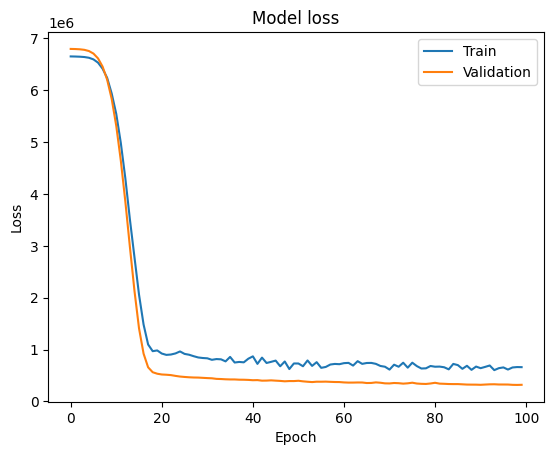

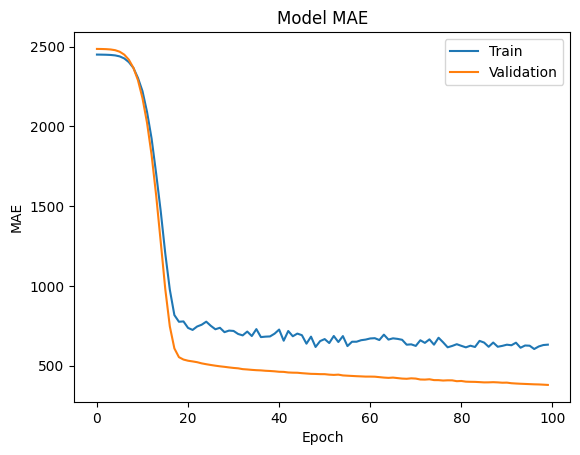

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [22]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 11
Datetime: 2024-10-28 15:11:50
Python Version: 3.12.4
-----------------------------------
